Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Get the dataset as a dataframe

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

# Data Preprocessing for Date and Time Features

This section of the code focuses on preprocessing the date and time columns in the dataset to create a unified datetime column.

1. **Stripping Whitespace**:
   - `data['date']` and `data['time']`: Any leading and trailing whitespace in the 'date' and 'time' columns is removed using the `.str.strip()` method. This step ensures that the date and time strings are in a consistent format, which is crucial for successful parsing in the next step.

2. **Combining Date and Time Columns**:
   - `data['datetime']`: The 'date' and 'time' columns are concatenated with a space in between to form a single string representing the datetime. This combination is necessary to create a unified datetime object from the separate date and time information.

3. **Converting to DateTime Object**:
   - `pd.to_datetime`: The concatenated string is then converted into a datetime object using Pandas' `to_datetime` function. The `format` parameter is specified as '%d-%b-%y %H:%M:%S', which matches the format of the input strings, ensuring accurate parsing.
   - The resultant 'datetime' column now provides a more useful and standardized format for any subsequent data analysis or time series modeling, integrating both date and time information into a single, coherent column.

In [5]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

## Extracting Date and Time Components

This part of the code is focused on extracting specific date and time components from the unified 'datetime' column in the data. This process is crucial for detailed time series analysis or for creating features that might be relevant for predictive modeling.

By breaking down the datetime into these individual components, the dataset is enriched with additional features that can provide deeper insights during data exploration or enhance the performance of predictive models.

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

## Finalizing Data Preprocessing for Date and Time Features

This section of the code is dedicated to finalizing the preprocessing steps for the dataset, ensuring it is organized and formatted appropriately for further analysis or modeling.

1. **Sorting Data by DateTime**:
   - The dataset is sorted based on the 'datetime' column using `data.sort_values(by='datetime')`. Sorting by datetime is essential for our time series models, as it ensures the data is in chronological order.

2. **Dropping Unnecessary Columns**:
   - `data.drop(...)`: The original 'date', 'time', 'datetime', and 'type' columns are dropped from the dataset. These columns are no longer needed as we have extracted all the required information into separate features.
   - The `inplace=True` parameter is used to modify the data frame in place, without creating a new one.

3. **Adjusting Feature Order and Data Type**:
   - `order`: A predefined order of features is specified, including the extracted date and time components, feature columns like 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', etc., and the 'label' column.
   - `data = data[order].astype('int32')`: The dataset is then reorganized to follow this specific order, and the data type of all columns is converted to 'int32'. This step ensures that the dataset has a consistent format and is optimized for memory usage, which can be particularly important for large datasets.

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

---
# Data Split
## Training, and Testing Sets
In this project, I utilized both training and test sets. Initially, I designated 80% of the data as the training set and the remaining 20% as an unseen test set. This division ensures that the model has sufficient data for learning during the training process, enhancing its accuracy and robustness while preventing underfitting. Moreover, using 20% of unseen data as an independent test set to evaluate the model's final performance helps in assessing the model's generalization capability on new data, rather than merely measuring its fit on the training data.

The approach here differs from using sklearn.model_selection.train_test_split. We employed a Recurrent Neural Network with Long Short-Term Memory (LSTM), necessitating the preservation of the dataset's chronological order. This is done to maintain the continuity of the time series data, enabling the network to more effectively learn and predict patterns and trends within the time series.

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

---
# Data preprocessing 
## Feature Scaling
Feature scaling is a crucial step to enhance the performance and convergence speed of the model. In this part of the code, we performed the following actions:

1. **Selecting Feature Columns**: We created a list of feature columns `feature_columns`, which includes all columns except the 'label' column. This is because the 'label' column is the target variable and should not be considered for feature scaling.

2. **Applying MinMax Scaling**: We used `MinMaxScaler` to scale the features. This scaler transforms all feature values to a range between 0 and 1. Such scaling is beneficial for maintaining relative scales between different features and also prevents potential negative impacts of extreme values on model training.

3. **Transforming Training and Test Data**: The `fit_transform` method is applied to the training data to learn the distribution of the data and transform it. For the test data, we only use the `transform` method, ensuring that we scale the test data using the same parameters (learned from the training data) to avoid data leakage, which is crucial for an accurate evaluation of model performance.

4. **Viewing Information of Transformed Training Data**: Through `X_train.info()`, we can view the information of the scaled training dataset, including the data type and the number of non-null values for each feature. This helps to verify that the scaling process has been correctly executed and ensures that the dataset is ready for model training.

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


---
# Model Implementation
## Lightweight LSTM Model Implementation

In this task, we aim to build a lightweight Long Short-Term Memory (LSTM) network for handling time series data. The objective of this model is to optimize performance while reducing the demand for computational resources. To achieve this goal, we will employ several key design strategies.

## Model Construction
Firstly, we have defined a PyTorch-based LSTM model class `LightweightLSTM`. This class comprises the following main components:
- **Initialization Function** (`__init__` method): We set the input size (`input_size`), hidden layer size (`hidden_size`), output size (`output_size`), and other optional parameters such as the number of layers (`num_layers`) and a width multiplier (`width_multiplier`). These parameters allow us to customize the model’s size and complexity based on the task requirements.
- **Width Adjustment**: The hidden layer size (`adjusted_hidden_size`) is adjusted using the width multiplier, making the model more flexible and lightweight. This multiplier allows us to adjust its capacity while maintaining the model structure, thus adapting to different computational and performance requirements.
- **LSTM Layer**: An LSTM layer with the adjusted hidden layer size is defined to process the input sequence data. We use the `batch_first=True` parameter, enabling the model to handle batch data more conveniently.
- **Fully Connected Layer**: A linear layer (`nn.Linear`) maps the output of the LSTM to the desired output size.

## Forward Propagation
In the `forward` method, we describe the process of data propagation through the model:
- **LSTM Processing**: The input data `x` passes through the LSTM layer, producing feature vectors that contain the results for each time step.
- **Extracting the Output of the Last Time Step**: In many time series tasks, the output of the last time step is particularly important. We extract this part of the data from the LSTM output.
- **Output Layer**: Finally, we transform the output of the last time step into the final prediction result through the fully connected layer.

With this design, our `LightweightLSTM` model can effectively process time series data while maintaining a lower computational complexity, making it suitable for resource-constrained environments or applications requiring quick responses.

## Problem Formulation

In this task, we utilize the `LightweightLSTM` model to solve a binary classification problem, specifically determining the category of time series data. The key components of the problem formulation are detailed below:

- **Objective**: The objective is to use the `LightweightLSTM` model to predict binary outcomes based on input time series data. This means that for each input sequence, the model needs to determine whether it belongs to category 0 or category 1.

- **Input**: The input data $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_T\}$ is a time series, where each $\mathbf{x}_t \in \mathbb{R}^{n}$ is an $n$-dimensional feature vector at time point $t$.

- **Output**: The output $\hat{y}$ of the model is a probability value, indicating the likelihood of the input sequence belonging to a specific category. Since this is a binary classification task, $\hat{y} \in [0, 1]$.

- **Model**: `LightweightLSTM` is a neural network based on LSTM architecture, particularly suited for processing time series data. The model learns temporal dependencies through its LSTM layers and fully connected layer, and outputs the classification probability.

- **Loss Function**: We use the Binary Cross-Entropy Loss (BCE) to quantify the difference between the model predictions and the actual labels. The loss function is defined as:
$$L(\mathbf{y}, \hat{\mathbf{y}}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\sigma(\hat{y}_i)) + (1 - y_i) \cdot \log(1 - \sigma(\hat{y}_i)) \right]$$
  where $N$ is the number of samples, $y_i$ is the actual class label of sample $i$ (0 or 1), $\hat{y}_i$ is the predicted output of the model for sample $i$, and $\sigma$ is the Sigmoid function.

- **Optimization Objective**: The optimization objective is to minimize the Binary Cross-Entropy Loss, i.e., finding a set of parameters $\theta$ that minimizes $L(\mathbf{y}, \hat{\mathbf{y}}; \theta)$.

In [10]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

## LSTM Model Instantiation

In this section of the code, we instantiate the `LightweightLSTM` model with specific hyperparameters tailored for our binary classification task on time series data. The configuration of the model is as follows:

1. **Defining Hyperparameters**:
   - `features_num`: This represents the number of input features in the dataset, determined by `X_train.shape[1]`. It sets the input size for our LSTM model.
   - `hidden_neurons_num`: We have set the number of neurons in each hidden layer of the LSTM to 512. This number defines the capacity and complexity of the LSTM layers.
   - `output_neurons_num`: Since this is a binary classification task, the number of output neurons is set to 1. The output of the model will represent the probability of the input belonging to one of the two classes.
   - `lstm_num_layers`: The model is configured with 2 LSTM layers. Multiple layers can help the model learn more complex patterns in the data.
   - `multiplier`: A width multiplier set to 1, indicating that we are using the base size for the hidden layers without any scaling.

2. **Model Initialization**:
   - The `LightweightLSTM` model is initialized with these hyperparameters. This step creates a model instance that is ready to be trained on our dataset.
   - The model is then transferred to the designated computing device with `.to(device)`. This ensures that the model will utilize the correct hardware (such as a GPU) for training and inference, improving computational efficiency.

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

## Computing Class Weights to Balance the Dataset

In our task, the occurrence of attacks (positive samples) in network data is typically less frequent compared to normal (negative samples) traffic, leading to an issue of class imbalance in our dataset. To address this issue and enhance the model's performance in detecting attacks, we have adopted a method of computing class weights.

1. **Calculating Weights Using `compute_class_weight`**:
   - We calculate weights for each category using the `compute_class_weight` function from scikit-learn. These weights are determined based on their frequency of occurrence in the training set (`y_train`).
   - Setting `class_weight='balanced'` ensures that less frequently occurring categories (in our case, attack data) are assigned higher weights.
   - `classes=np.unique(y_train)`: This ensures that the weight calculation encompasses all unique class labels.

2. **Converting to PyTorch Tensor and Assigning to the Device**:
   - The calculated class weights are then converted into a PyTorch tensor, as our model is trained using PyTorch.

By this approach, we adjust the model's handling of class imbalance, thereby making it more effective in detecting potential attacks in IoT device network data. This helps to increase the model's accuracy and sensitivity in detecting attack categories that occur less frequently.

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

## Setting Up the Loss Function and Optimizer

In this part of the code, we configure the loss function and optimizer for our neural network model, which is crucial for the model's training process.

1. **Defining Custom Weights for Loss Function**:
   - `weights`: We create a tensor `weights` with two elements. The first element is for the negative class (normal data), set to 1. The second element is the computed weight for the positive class (attack data), derived from `class_weights[1]`. This approach emphasizes the importance of correctly classifying the less frequent positive class in our dataset.
   - The tensor `weights` is defined with data type `torch.float`, ensuring compatibility with PyTorch operations.

2. **Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss)**:
   - `criterion`: We use the `nn.BCEWithLogitsLoss` loss function from PyTorch, which combines a Sigmoid layer and the BCELoss in one single class. This is particularly useful for binary classification tasks.
   - The argument `torch.FloatTensor([weights[1] / weights[0]])` is passed to the loss function, which adjusts the loss calculation to account for the imbalance between the positive and negative classes.

3. **Optimizer Configuration**:
   - `optimizer`: We use the Adam optimizer, a popular choice for training deep learning models. It's defined with `optim.Adam(model.parameters(), lr=0.0001)`, where `lr=0.0001` specifies a learning rate of 0.0001. This learning rate determines the step size during the gradient descent optimization process.

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## Preparing the Training Data

In this section of the code, we are preparing our training data for the neural network model, particularly for batch processing during training. This involves converting the data into PyTorch tensors, organizing it into a dataset, and finally creating a data loader for efficient batch processing.

1. **Setting Batch Size**:
   - `batch_size`: We set the batch size to 128. Batch size is a key hyperparameter in training neural networks, determining the number of samples processed before the model's internal parameters are updated.

2. **Converting Training Data to PyTorch Tensors**:
   - `X_train_tensor`: The feature data (`X_train`) from the training set is converted into a PyTorch tensor. We use `.float()` to ensure the data is in floating-point format, which is required for neural network operations in PyTorch.
   - `y_train_tensor`: Similarly, the target variable (`y_train`) is converted into a PyTorch tensor.
   - Both tensors are reshaped with `.unsqueeze(1)` to add an additional dimension, aligning them with the expected input format for the neural network.

3. **Creating TensorDataset and DataLoader**:
   - `train_dataset`: We use `TensorDataset` to create a dataset from `X_train_tensor` and `y_train_tensor`. `TensorDataset` is a convenient wrapper for combining features and target tensors.
   - `train_loader`: The `DataLoader` is created from the `train_dataset`. It facilitates efficient iteration over the dataset in batches of size `batch_size`, here 128. The `shuffle=False` parameter indicates that the data will not be shuffled at each epoch. In certain time-series applications, maintaining the sequence of data is crucial.

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

## Training Loop

This section of the code outlines the training process of the neural network model over a specified number of epochs. 

1. **Setting Up the Training**:
   - `num_epochs`: The total number of epochs (iterations over the entire dataset) is set to 100. An epoch is one complete cycle through the training data.
   - `loss_list` and `acc_list`: These lists are initialized to store the loss and accuracy values for each epoch, allowing for tracking the model's performance over time.

2. **Training Loop**:
   - The loop iterates over the number of epochs specified. In each epoch, the model's parameters are updated based on the training data.
   - `model.train()`: This sets the model to training mode, enabling certain layers to function appropriately during training.
   - `running_loss` and `running_accuracy`: Variables initialized to accumulate the loss and accuracy for each batch within an epoch.

3. **Batch Processing Within Each Epoch**:
   - The inner loop iterates over each batch of data in `train_loader`.
   - **Forward Pass (FP)**: The model computes the output (`outputs`) for a batch of inputs.
   - **Loss Computation**: The loss between the outputs and the ground truth labels is calculated using the criterion defined earlier.
   - **Backpropagation and Optimization (BP)**: The gradients are computed (`loss.backward()`) and the optimizer updates the model parameters (`optimizer.step()`).

4. **Calculating Performance Indicators**:
   - After processing each batch, the model's predictions and loss are used to calculate the running accuracy and loss.
   - These values are then averaged over all batches to obtain the epoch's average loss and accuracy.

5. **Logging and Progress Update**:
   - At the end of each epoch, the average loss and accuracy are printed, and the progress bar is updated.

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

    pbar.update(1)
pbar.reset()

  1%|          | 1/100 [00:11<18:21, 11.12s/it]

Epoch [1/100], Loss: 0.5964092749277182, Accuracy: 0.8649068593314764


  2%|▏         | 2/100 [00:22<18:10, 11.13s/it]

Epoch [2/100], Loss: 0.6697538053469778, Accuracy: 0.8352324164345404


  3%|▎         | 3/100 [00:33<17:44, 10.98s/it]

Epoch [3/100], Loss: 0.6841559864119013, Accuracy: 0.8446204735376045


  4%|▍         | 4/100 [00:43<17:27, 10.91s/it]

Epoch [4/100], Loss: 0.6319667941687636, Accuracy: 0.8554535167130919


  5%|▌         | 5/100 [00:54<17:15, 10.90s/it]

Epoch [5/100], Loss: 0.6062442797480067, Accuracy: 0.8665389972144847


  6%|▌         | 6/100 [01:05<17:02, 10.88s/it]

Epoch [6/100], Loss: 0.5614399757185735, Accuracy: 0.8753830083565459


  7%|▋         | 7/100 [01:16<16:49, 10.86s/it]

Epoch [7/100], Loss: 0.5116179810095153, Accuracy: 0.8955562325905293


  8%|▊         | 8/100 [01:27<16:35, 10.82s/it]

Epoch [8/100], Loss: 0.5134656784693081, Accuracy: 0.8870778203342619


  9%|▉         | 9/100 [01:37<16:21, 10.78s/it]

Epoch [9/100], Loss: 0.6041127104192278, Accuracy: 0.8602759401114206


 10%|█         | 10/100 [01:48<16:10, 10.78s/it]

Epoch [10/100], Loss: 0.6575821128615906, Accuracy: 0.8291303969359332


 11%|█         | 11/100 [01:59<16:01, 10.81s/it]

Epoch [11/100], Loss: 0.49607472573543293, Accuracy: 0.8885750348189415


 12%|█▏        | 12/100 [02:10<15:57, 10.88s/it]

Epoch [12/100], Loss: 0.4890700469475034, Accuracy: 0.8862943941504178


 13%|█▎        | 13/100 [02:21<15:44, 10.86s/it]

Epoch [13/100], Loss: 0.4930179383959107, Accuracy: 0.8849277506963789


 14%|█▍        | 14/100 [02:31<15:27, 10.78s/it]

Epoch [14/100], Loss: 0.5078660347871413, Accuracy: 0.9012143105849583


 15%|█▌        | 15/100 [02:42<15:19, 10.82s/it]

Epoch [15/100], Loss: 0.4722110244461616, Accuracy: 0.9123911908077994


 16%|█▌        | 16/100 [02:53<15:00, 10.72s/it]

Epoch [16/100], Loss: 0.4486743103906313, Accuracy: 0.9126175139275766


 17%|█▋        | 17/100 [03:03<14:40, 10.61s/it]

Epoch [17/100], Loss: 0.45348908452101105, Accuracy: 0.9204604805013927


 18%|█▊        | 18/100 [03:14<14:36, 10.70s/it]

Epoch [18/100], Loss: 0.4649880576380443, Accuracy: 0.9163126740947075


 19%|█▉        | 19/100 [03:25<14:27, 10.70s/it]

Epoch [19/100], Loss: 0.47569956153184345, Accuracy: 0.9111028899721448


 20%|██        | 20/100 [03:36<14:19, 10.74s/it]

Epoch [20/100], Loss: 0.44825285205602183, Accuracy: 0.9197510445682451


 21%|██        | 21/100 [03:46<13:59, 10.62s/it]

Epoch [21/100], Loss: 0.4480130790377366, Accuracy: 0.9178882311977716


 22%|██▏       | 22/100 [03:56<13:41, 10.53s/it]

Epoch [22/100], Loss: 0.4579092515926595, Accuracy: 0.9141800139275766


 23%|██▎       | 23/100 [04:07<13:26, 10.48s/it]

Epoch [23/100], Loss: 0.4796259573314922, Accuracy: 0.9051357938718663


 24%|██▍       | 24/100 [04:17<13:14, 10.45s/it]

Epoch [24/100], Loss: 0.4839813681076184, Accuracy: 0.9024068593314764


 25%|██▌       | 25/100 [04:27<13:00, 10.41s/it]

Epoch [25/100], Loss: 0.4828386830401777, Accuracy: 0.9030510097493036


 26%|██▌       | 26/100 [04:38<12:47, 10.38s/it]

Epoch [26/100], Loss: 0.47730019856569017, Accuracy: 0.9033861420612813


 27%|██▋       | 27/100 [04:48<12:35, 10.35s/it]

Epoch [27/100], Loss: 0.4770057977139606, Accuracy: 0.906637360724234


 28%|██▊       | 28/100 [04:58<12:24, 10.34s/it]

Epoch [28/100], Loss: 0.472068597969348, Accuracy: 0.9052924791086351


 29%|██▉       | 29/100 [05:09<12:13, 10.33s/it]

Epoch [29/100], Loss: 0.47455056945826307, Accuracy: 0.9050313370473537


 30%|███       | 30/100 [05:19<12:02, 10.32s/it]

Epoch [30/100], Loss: 0.4721288842897627, Accuracy: 0.9051619080779945


 31%|███       | 31/100 [05:29<11:51, 10.32s/it]

Epoch [31/100], Loss: 0.4663435918978452, Accuracy: 0.9071770543175487


 32%|███▏      | 32/100 [05:39<11:41, 10.32s/it]

Epoch [32/100], Loss: 0.4584492962639296, Accuracy: 0.9092836002785515


 33%|███▎      | 33/100 [05:50<11:30, 10.31s/it]

Epoch [33/100], Loss: 0.44787338677632027, Accuracy: 0.9115511838440111


 34%|███▍      | 34/100 [06:00<11:20, 10.31s/it]

Epoch [34/100], Loss: 0.4367873638668948, Accuracy: 0.9136142061281337


 35%|███▌      | 35/100 [06:10<11:09, 10.30s/it]

Epoch [35/100], Loss: 0.4252429143711211, Accuracy: 0.9156946378830083


 36%|███▌      | 36/100 [06:21<10:59, 10.30s/it]

Epoch [36/100], Loss: 0.4140134099191455, Accuracy: 0.9188413997214485


 37%|███▋      | 37/100 [06:31<10:49, 10.31s/it]

Epoch [37/100], Loss: 0.405167832823744, Accuracy: 0.9211829735376045


 38%|███▊      | 38/100 [06:41<10:39, 10.31s/it]

Epoch [38/100], Loss: 0.3965442162632981, Accuracy: 0.922841225626741


 39%|███▉      | 39/100 [06:52<10:28, 10.30s/it]

Epoch [39/100], Loss: 0.38843455063943333, Accuracy: 0.9241556406685236


 40%|████      | 40/100 [07:02<10:18, 10.30s/it]

Epoch [40/100], Loss: 0.3798329206956802, Accuracy: 0.9263797005571031


 41%|████      | 41/100 [07:12<10:08, 10.31s/it]

Epoch [41/100], Loss: 0.3722133932188011, Accuracy: 0.9286037604456825


 42%|████▏     | 42/100 [07:23<09:57, 10.30s/it]

Epoch [42/100], Loss: 0.3661952191305293, Accuracy: 0.9303185933147632


 43%|████▎     | 43/100 [07:33<09:47, 10.30s/it]

Epoch [43/100], Loss: 0.3625844347315135, Accuracy: 0.9291303969359331


 44%|████▍     | 44/100 [07:43<09:37, 10.31s/it]

Epoch [44/100], Loss: 0.36051277555206024, Accuracy: 0.9291565111420613


 45%|████▌     | 45/100 [07:53<09:26, 10.30s/it]

Epoch [45/100], Loss: 0.3598570855872306, Accuracy: 0.9301053272980502


 46%|████▌     | 46/100 [08:04<09:16, 10.31s/it]

Epoch [46/100], Loss: 0.35990324631338194, Accuracy: 0.9300922701949861


 47%|████▋     | 47/100 [08:14<09:05, 10.30s/it]

Epoch [47/100], Loss: 0.36035372328536885, Accuracy: 0.9298964136490251


 48%|████▊     | 48/100 [08:24<08:55, 10.30s/it]

Epoch [48/100], Loss: 0.36084967570328513, Accuracy: 0.9294742339832869


 49%|████▉     | 49/100 [08:35<08:45, 10.30s/it]

Epoch [49/100], Loss: 0.37693052105072367, Accuracy: 0.9254787604456824


 50%|█████     | 50/100 [08:45<08:34, 10.30s/it]

Epoch [50/100], Loss: 0.45866409482776205, Accuracy: 0.9101149025069638


 51%|█████     | 51/100 [08:55<08:24, 10.30s/it]

Epoch [51/100], Loss: 0.4003969641442098, Accuracy: 0.9176488509749303


 52%|█████▏    | 52/100 [09:06<08:14, 10.30s/it]

Epoch [52/100], Loss: 0.3940097110101944, Accuracy: 0.9185106197771588


 53%|█████▎    | 53/100 [09:16<08:04, 10.30s/it]

Epoch [53/100], Loss: 0.3903284710767466, Accuracy: 0.9184453342618384


 54%|█████▍    | 54/100 [09:26<07:53, 10.30s/it]

Epoch [54/100], Loss: 0.39199766308407424, Accuracy: 0.9182842966573816


 55%|█████▌    | 55/100 [09:36<07:43, 10.30s/it]

Epoch [55/100], Loss: 0.3959142088812847, Accuracy: 0.9166521587743732


 56%|█████▌    | 56/100 [09:47<07:33, 10.30s/it]

Epoch [56/100], Loss: 0.40301148244951435, Accuracy: 0.911320508356546


 57%|█████▋    | 57/100 [09:57<07:22, 10.30s/it]

Epoch [57/100], Loss: 0.4494313190900809, Accuracy: 0.9073555013927577


 58%|█████▊    | 58/100 [10:07<07:12, 10.30s/it]

Epoch [58/100], Loss: 0.4384865179629783, Accuracy: 0.9067896935933147


 59%|█████▉    | 59/100 [10:18<07:02, 10.30s/it]

Epoch [59/100], Loss: 0.4337192275473291, Accuracy: 0.9097144846796658


 60%|██████    | 60/100 [10:28<06:52, 10.30s/it]

Epoch [60/100], Loss: 0.41720377543919324, Accuracy: 0.9122867339832869


 61%|██████    | 61/100 [10:38<06:41, 10.30s/it]

Epoch [61/100], Loss: 0.46658633381142356, Accuracy: 0.9158426183844011


 62%|██████▏   | 62/100 [10:49<06:31, 10.31s/it]

Epoch [62/100], Loss: 0.46398521040093904, Accuracy: 0.9174051183844011


 63%|██████▎   | 63/100 [10:59<06:21, 10.31s/it]

Epoch [63/100], Loss: 0.43890143102295986, Accuracy: 0.9184670961002785


 64%|██████▍   | 64/100 [11:09<06:11, 10.31s/it]

Epoch [64/100], Loss: 0.4327687025331207, Accuracy: 0.9177141364902507


 65%|██████▌   | 65/100 [11:20<06:01, 10.32s/it]

Epoch [65/100], Loss: 0.4224160557830276, Accuracy: 0.9210306406685237


 66%|██████▌   | 66/100 [11:30<05:50, 10.31s/it]

Epoch [66/100], Loss: 0.40745034645481865, Accuracy: 0.923058844011142


 67%|██████▋   | 67/100 [11:40<05:40, 10.31s/it]

Epoch [67/100], Loss: 0.3991692967968981, Accuracy: 0.9260402158774373


 68%|██████▊   | 68/100 [11:50<05:30, 10.32s/it]

Epoch [68/100], Loss: 0.39570602907417335, Accuracy: 0.9282990947075209


 69%|██████▉   | 69/100 [12:01<05:20, 10.33s/it]

Epoch [69/100], Loss: 0.39035723397416233, Accuracy: 0.9279987813370474


 70%|███████   | 70/100 [12:11<05:09, 10.32s/it]

Epoch [70/100], Loss: 0.38201895046139067, Accuracy: 0.9275504874651811


 71%|███████   | 71/100 [12:21<04:59, 10.32s/it]

Epoch [71/100], Loss: 0.3789129540331596, Accuracy: 0.9276288300835654


 72%|███████▏  | 72/100 [12:32<04:48, 10.31s/it]

Epoch [72/100], Loss: 0.3732728757335329, Accuracy: 0.9284383704735376


 73%|███████▎  | 73/100 [12:42<04:38, 10.31s/it]

Epoch [73/100], Loss: 0.3600947451284044, Accuracy: 0.9275113161559888


 74%|███████▍  | 74/100 [12:52<04:27, 10.30s/it]

Epoch [74/100], Loss: 0.3572993777487344, Accuracy: 0.9280118384401114


 75%|███████▌  | 75/100 [13:03<04:17, 10.32s/it]

Epoch [75/100], Loss: 0.36948809581301, Accuracy: 0.9290302924791086


 76%|███████▌  | 76/100 [13:13<04:07, 10.31s/it]

Epoch [76/100], Loss: 0.35878085617469296, Accuracy: 0.9260663300835654


 77%|███████▋  | 77/100 [13:23<03:57, 10.31s/it]

Epoch [77/100], Loss: 0.3624829358606835, Accuracy: 0.9236855849582173


 78%|███████▊  | 78/100 [13:34<03:46, 10.30s/it]

Epoch [78/100], Loss: 0.36716248564604503, Accuracy: 0.9210741643454039


 79%|███████▉  | 79/100 [13:44<03:36, 10.31s/it]

Epoch [79/100], Loss: 0.360405634015213, Accuracy: 0.9256572075208913


 80%|████████  | 80/100 [13:54<03:26, 10.31s/it]

Epoch [80/100], Loss: 0.3585944276542616, Accuracy: 0.9242644498607242


 81%|████████  | 81/100 [14:05<03:15, 10.31s/it]

Epoch [81/100], Loss: 0.35407325109796445, Accuracy: 0.9251653899721448


 82%|████████▏ | 82/100 [14:15<03:05, 10.31s/it]

Epoch [82/100], Loss: 0.3539932827723654, Accuracy: 0.9243384401114206


 83%|████████▎ | 83/100 [14:25<02:55, 10.31s/it]

Epoch [83/100], Loss: 0.35292292155264915, Accuracy: 0.9243036211699165


 84%|████████▍ | 84/100 [14:35<02:44, 10.31s/it]

Epoch [84/100], Loss: 0.3536593136660204, Accuracy: 0.9237900417827298


 85%|████████▌ | 85/100 [14:46<02:34, 10.30s/it]

Epoch [85/100], Loss: 0.35403552281330714, Accuracy: 0.9233896239554318


 86%|████████▌ | 86/100 [14:56<02:24, 10.31s/it]

Epoch [86/100], Loss: 0.34941604498810963, Accuracy: 0.9247519150417828


 87%|████████▋ | 87/100 [15:06<02:13, 10.31s/it]

Epoch [87/100], Loss: 0.3483125853816158, Accuracy: 0.9251653899721448


 88%|████████▊ | 88/100 [15:17<02:03, 10.31s/it]

Epoch [88/100], Loss: 0.3491470380147286, Accuracy: 0.924791086350975


 89%|████████▉ | 89/100 [15:27<01:53, 10.31s/it]

Epoch [89/100], Loss: 0.36071007054782067, Accuracy: 0.92224930362117


 90%|█████████ | 90/100 [15:37<01:43, 10.30s/it]

Epoch [90/100], Loss: 0.39128883811902376, Accuracy: 0.9251479805013928


 91%|█████████ | 91/100 [15:48<01:32, 10.30s/it]

Epoch [91/100], Loss: 0.36006560839362556, Accuracy: 0.9215094011142061


 92%|█████████▏| 92/100 [15:58<01:22, 10.30s/it]

Epoch [92/100], Loss: 0.34874802233375346, Accuracy: 0.9302097841225627


 93%|█████████▎| 93/100 [16:08<01:12, 10.31s/it]

Epoch [93/100], Loss: 0.3446778446900666, Accuracy: 0.929099930362117


 94%|█████████▍| 94/100 [16:18<01:01, 10.30s/it]

Epoch [94/100], Loss: 0.33107457966181336, Accuracy: 0.9371431058495822


 95%|█████████▌| 95/100 [16:29<00:51, 10.30s/it]

Epoch [95/100], Loss: 0.3617299519207221, Accuracy: 0.9156467618384401


 96%|█████████▌| 96/100 [16:39<00:41, 10.28s/it]

Epoch [96/100], Loss: 0.35252909171415936, Accuracy: 0.9274982590529248


 97%|█████████▋| 97/100 [16:49<00:30, 10.29s/it]

Epoch [97/100], Loss: 0.3388090946832116, Accuracy: 0.9307277158774373


 98%|█████████▊| 98/100 [17:00<00:20, 10.30s/it]

Epoch [98/100], Loss: 0.33284261000367543, Accuracy: 0.9323642061281338


 99%|█████████▉| 99/100 [17:10<00:10, 10.30s/it]

Epoch [99/100], Loss: 0.33026519210583544, Accuracy: 0.9334566504178273


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.32758701475072804, Accuracy: 0.9344272284122562


## Plotting Training Loss and Accuracy

This section of the code is focused on visualizing the training performance of the model in terms of loss and accuracy across epochs.

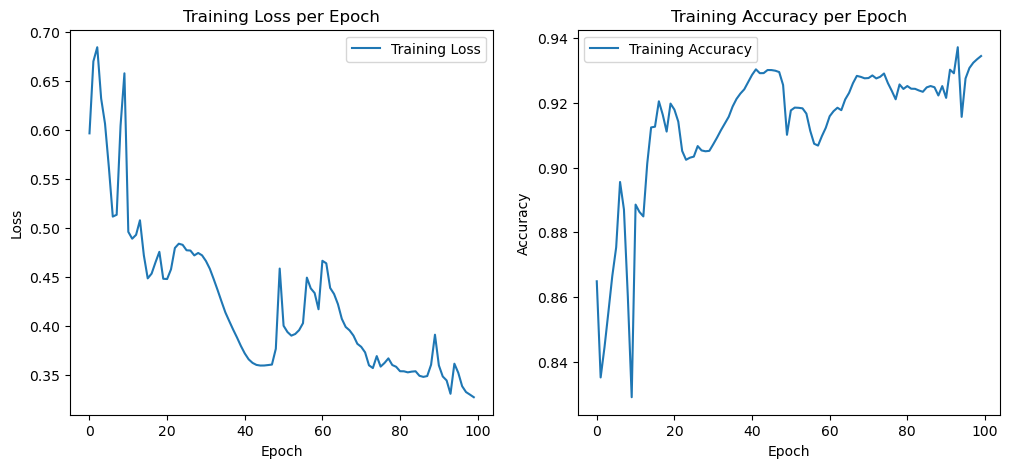

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluating the Model on the Test Dataset

This code section describes the process of evaluating the trained neural network model on the test dataset to assess its performance and generalization ability.

1. **Preparing Test Data**:
   - `X_test_tensor`: The test feature data (`X_test`) is converted into a PyTorch tensor, ensuring it is in the correct format (floating point) and dimensionality for the model.

2. **Model Evaluation Mode**:
   - `model.eval()`: This command sets the model to evaluation mode, disabling certain layers that are only active during training.

3. **Generating Predictions**:
   - The model is used to compute the output for the test data (`outputs`).
   - `torch.no_grad()`: Ensures that no gradient calculations are performed, which is necessary for evaluation as it saves memory and computations.
   - `probabilities`: The raw outputs from the model are passed through a sigmoid function to convert them into probabilities.
   - `predictions`: Probabilities are converted into binary predictions based on a threshold of 0.5.

4. **Calculating Performance Metrics**:
   - Various metrics such as accuracy, precision, recall, and F1 score are computed to measure the model's performance. These metrics provide insights into how well the model is performing, particularly in terms of identifying positive cases (attacks) correctly.

5. **Displaying Evaluation Results**:
   - The performance metrics are printed, giving a comprehensive view of the model's effectiveness on the test dataset.

This evaluation step is crucial for understanding the real-world applicability of the model in classifying IoT device data, specifically in distinguishing between normal operations and potential security threats.

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.9327982729504344 , Precision:  0.8335528482054659 , Recall:  0.6399140546006067 , F1:  0.724009724009724


# Saving the Trained Model

This section of the code deals with saving the trained model for future inference purposes. The model can be deployed either directly on IoT devices or used in a fog computing setup through local routers or servers, which helps in offloading computational tasks from the local IoT devices.

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_lstm_{current_time}.pt"
if multiplier == 1:
    model_filename = f"model_lstm_{current_time}_without_width_multiplier.pt"
full_path = os.path.join(save_folder, model_filename)
torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: save_model/model_lstm_2023-11-23_11-01-34.pt
